In [1]:
# packages

# JAX
import jax.ops as jop
import jax.numpy as jnp
from jax import grad, vmap, hessian

# Numpy
import numpy as onp
from numpy import random 

# Plot
import matplotlib.pyplot as plt

# Scipy
import scipy.sparse
from scipy.sparse import diags
from scipy.sparse import identity

We solve the following regularized Eikonal equation 
\begin{equation*}
\begin{aligned}
& |\nabla u(x)|^2 = f(x)^2 + \epsilon \Delta u, x \in \Omega=[0,1]^2\\
& u=0 \text{ on } \partial \Omega
\end{aligned}
\end{equation*}
We set $f(x)=1$

In [2]:
# fix random seeds, for generating reference solution & sampled points
random.seed(20)

# boundary condition
def u(x1, x2):
    return 0

# right hand side
def f(x1, x2):
    return 1

We solve the regularized Eikonal equation via Cole-Hopf transformation

Let $v = \exp(-u/\epsilon)$, then $v$ solves
$$v- \epsilon^2 \Delta v = 0$$

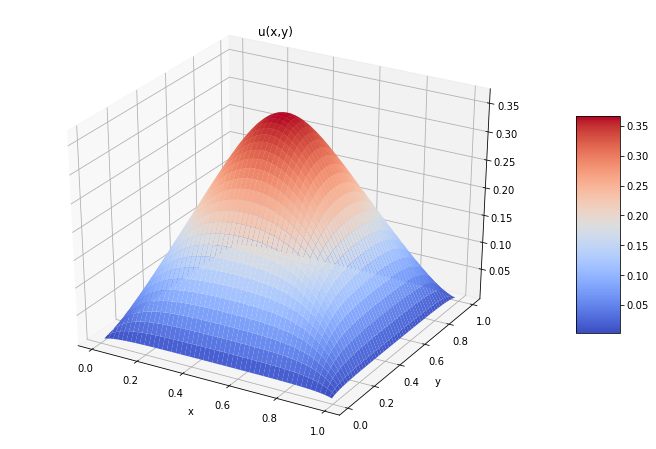

In [3]:
epsilon = 1e-1

# solve Eikonal equation
def Reg_Eikonal(N, epsilon):
    hg = onp.array(1/(N+1))
    x_mid = (onp.arange(0,N+1,1)+0.5)*hg
    x_grid = (onp.arange(1,N+1,1))*hg
    mid, grid = onp.meshgrid(x_mid, x_grid)
    a1 = onp.ones((N,N+1))
    a2 = onp.ones((N+1,N))

    # diagonal element of A
    a_diag = onp.reshape(a1[:,:N]+a1[:,1:]+a2[:N,:]+a2[1:,:], (1,-1))
    
    # off-diagonals
    a_super1 = onp.reshape(onp.append(a1[:,1:N], onp.zeros((N,1)), axis = 1), (1,-1))
    a_super2 = onp.reshape(a2[1:N,:], (1,-1))
    
    A = diags([[-a_super2[onp.newaxis, :]], [-a_super1[onp.newaxis, :]], [a_diag], [-a_super1[onp.newaxis, :]], [-a_super2[onp.newaxis, :]]], [-N,-1,0,1,N], shape=(N**2, N**2))
    XX, YY = onp.meshgrid(x_grid, x_grid)
    f = onp.zeros((N,N))
    f[0,:] = f[0,:] + epsilon**2 / (hg**2)
    f[N-1,:] = f[N-1,:] + epsilon**2 / (hg**2)
    f[:, 0] = f[:, 0] + epsilon**2 / (hg**2)
    f[:, N-1] = f[:, N-1] + epsilon**2 / (hg**2)
    fv = f.flatten()
    fv = fv[:, onp.newaxis]
    
    mtx = identity(N**2)+(epsilon**2)*A/(hg**2)
    sol_v = scipy.sparse.linalg.spsolve(mtx, fv)
    sol_u = -epsilon*onp.log(sol_v)
    sol_u = onp.reshape(sol_u, (N,N))
    return XX, YY, sol_u

# plot figure
N_plot=100

XX, YY, sol_u = Reg_Eikonal(N_plot, epsilon)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(XX, YY, sol_u, cmap=plt.cm.coolwarm)
plt.xlabel('x')
plt.ylabel('y')
plt.title('u(x,y)')
fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
plt.show()


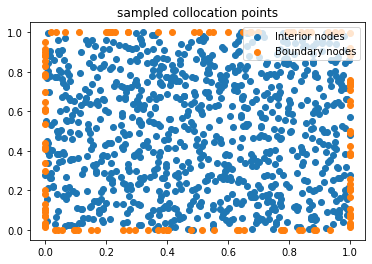

In [4]:
# sampled collocation points

def sample_points(N_domain, N_boundary):
    # interior nodes
    X_domain = random.uniform(0.0, 1.0, (N_domain, 2))
    X_boundary = onp.zeros((N_boundary, 2))

    # generate random boundary points on the faces of the domain 

    # bottom face
    X_boundary[range(int(N_boundary/4)), 0] = random.uniform(0.0, 1.0, int(N_boundary/4))
    # right face
    X_boundary[range(int(N_boundary/4), 2*int(N_boundary/4)), 0] += 1
    X_boundary[range(int(N_boundary/4), 2*int(N_boundary/4)), 1] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    # top face
    X_boundary[range(2*int(N_boundary/4), 3*int(N_boundary/4)), 0] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    X_boundary[range(2*int(N_boundary/4), 3*int(N_boundary/4)), 1] += 1
    # left face
    X_boundary[range(3*int(N_boundary/4), 4*int(N_boundary/4)), 1] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    
    return X_domain, X_boundary

N_pts = 30
N_domain_tot = N_pts**2
N_boundary_tot = 4*(N_pts+1)
X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

fig, ax = plt.subplots()
ax.scatter(X_domain_tot[range(N_domain_tot), 1], X_domain_tot[range(N_domain_tot), 0], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 1], X_boundary_tot[range(N_boundary_tot), 0], label='Boundary nodes')
ax.legend(loc="upper right")
plt.title('sampled collocation points')
plt.show()

In [5]:
# Define a real valued kernel kappa(x, y; sigma) \to R
def kappa(x1, x2, y1, y2, sigma):
    return jnp.exp(-(1/(2*sigma**2))*( (x1- y1)**2 + (x2 - y2)**2 ))
    
# define derivatives of the kernel 
def D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,2)(x1, x2, y1, y2, sigma)
    return val

def D_x1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,0)(x1, x2, y1, y2, sigma)
    return val

def D_x2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,1)(x1, x2, y1, y2, sigma)
    return val

def D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,3)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(D_y1_kappa,0)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(D_y2_kappa,0)(x1, x2, y1, y2, sigma)
    return val

def D_x2_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(D_y2_kappa,1)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa, 0), 0)(x1, x2, y1, y2, sigma)
    val += grad(grad(kappa, 1), 1)(x1, x2, y1, y2, sigma)
    return val

def Delta_y_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa, 2), 2)(x1, x2, y1, y2, sigma)
    val += grad(grad(kappa, 3), 3)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_Delta_y_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(Delta_y_kappa, 0), 0)(x1, x2, y1, y2, sigma)
    val += grad(grad(Delta_y_kappa, 1), 1)(x1, x2, y1, y2, sigma)
    return val


def Delta_x_D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(Delta_x_kappa,2)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(Delta_x_kappa,3)(x1, x2, y1, y2, sigma)
    return val


In [6]:
# vectorized construction of Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma):
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    Theta = onp.zeros((4*N_domain + N_boundary, 4*N_domain + N_boundary))

    # auxiliary variables to make things readable
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]

    Xdb0=jnp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=jnp.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior -- interior 
    XXdd0=jnp.transpose(jnp.tile(Xd0,(N_domain,1)))
    XXdd1=jnp.transpose(jnp.tile(Xd1,(N_domain,1)))

    # interior+boudary -- interior+bpundary
    XXdbdb0=jnp.transpose(jnp.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=jnp.transpose(jnp.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary
    XXddb0=jnp.transpose(jnp.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=jnp.transpose(jnp.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=jnp.tile(Xdb0,(N_domain,1))
    XXddb1_2=jnp.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix
    # interior v.s. interior 
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta[0:N_domain, 0:N_domain] =  jnp.reshape(val, (N_domain, N_domain))
    val = vmap(lambda x1, x2, y1, y2: D_x2_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta[N_domain:2*N_domain, N_domain:2*N_domain] =  jnp.reshape(val, (N_domain, N_domain))
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta[:N_domain, N_domain:2*N_domain] =  jnp.reshape(val, (N_domain, N_domain))
    Theta[N_domain:2*N_domain, :N_domain] =  jnp.transpose(jnp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: Delta_x_Delta_y_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta[2*N_domain:3*N_domain, 2*N_domain:3*N_domain] = jnp.reshape(val, (N_domain, N_domain))
    val = vmap(lambda x1, x2, y1, y2: Delta_x_D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta[2*N_domain:3*N_domain, :N_domain] = jnp.reshape(val, (N_domain, N_domain))
    Theta[:N_domain, 2*N_domain:3*N_domain] = jnp.transpose(jnp.reshape(val, (N_domain, N_domain)))
    val = vmap(lambda x1, x2, y1, y2: Delta_x_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),jnp.transpose(XXdd0).flatten(),jnp.transpose(XXdd1).flatten())
    Theta[2*N_domain:3*N_domain, N_domain:2*N_domain] = jnp.reshape(val, (N_domain, N_domain))
    Theta[N_domain:2*N_domain, 2*N_domain:3*N_domain] = jnp.transpose(jnp.reshape(val, (N_domain, N_domain)))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXdbdb0.flatten(),XXdbdb1.flatten(),jnp.transpose(XXdbdb0).flatten(),jnp.transpose(XXdbdb1).flatten())
    Theta[3*N_domain:, 3*N_domain:] =  jnp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary))

    # interior v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: D_x1_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta[:N_domain, 3*N_domain:] = jnp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta[3*N_domain:, :N_domain] = jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta[N_domain:2*N_domain, 3*N_domain:] = jnp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta[3*N_domain:, N_domain:2*N_domain] = jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    val = vmap(lambda x1, x2, y1, y2: Delta_x_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta[2*N_domain:3*N_domain, 3*N_domain:] = jnp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta[3*N_domain:, 2*N_domain:3*N_domain] = jnp.transpose(jnp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    # calculate trace
    trace1 = onp.trace(Theta[:N_domain, :N_domain])
    trace2 = onp.trace(Theta[N_domain:2*N_domain, N_domain:2*N_domain])
    trace3 = onp.trace(Theta[2*N_domain:3*N_domain, 2*N_domain:3*N_domain])
    trace4 = onp.trace(Theta[3*N_domain:, 3*N_domain:])
    ratio = [trace1/trace4, trace2/trace4, trace3/trace4]
    temp=onp.concatenate((ratio[0]*jnp.ones((1,N_domain)),ratio[1]*jnp.ones((1,N_domain)), ratio[2]*jnp.ones((1,N_domain)), jnp.ones((1,N_domain+N_boundary))), axis=1)
    Theta = Theta + set_nugget*onp.diag(temp[0])
    L = onp.linalg.cholesky(Theta)
    
    return L, ratio

# test
set_sigma = 0.2
set_nugget = 1e-4
L, ratio = assembly_Theta(X_domain_tot, X_boundary_tot, set_nugget, set_sigma)
print('trace ratio =', ratio)
print('observation: the trace ratio is not equal to 1, and our adaptive nugget term is effective')

trace ratio = [21.97265625, 21.97265625, 4394.53125]
observation: the trace ratio is not equal to 1, and our adaptive nugget term is effective


In [7]:

def J(v,rhs_f,bdy_g,L,epsilon):
    N_domain = rhs_f.shape[0]
    v0 = v[:N_domain]
    v1 = v[N_domain:2*N_domain]
    v2 = v[2*N_domain:]
    v3 = -(rhs_f**2 - v1**2 - v2**2)/epsilon
    
    vv = jnp.append(v1, v2)
    vv = jnp.append(vv, v3)
    vv = jnp.append(vv, v0)
    vv = jnp.append(vv, bdy_g)
    temp = jnp.linalg.solve(L,vv)
    
    return jnp.dot(temp, temp)

# gradient of loss functions
grad_J = grad(J)

# Hessian in the Gaussian Newton method
def GN_J(v,rhs_f,bdy_g,L,epsilon, v_old):
    N_domain = rhs_f.shape[0]
    v0_old = v_old[:N_domain]
    v1_old = v_old[N_domain:2*N_domain]
    v2_old = v_old[2*N_domain:]
    
    v0 = v[:N_domain]
    v1 = v[N_domain:2*N_domain]
    v2 = v[2*N_domain:]
    v3 = -(rhs_f**2 - 2*v1*v1_old - 2*v2*v2_old)/epsilon
    
    vv = jnp.append(v1, v2)
    vv = jnp.append(vv, v3)
    vv = jnp.append(vv, v0)
    vv = jnp.append(vv, bdy_g)
    temp = jnp.linalg.solve(L,vv)
    return jnp.dot(temp, temp)

Hessian_GN=hessian(GN_J)

def pde_solver(X_domain, X_boundary, nugget, max_iter, step_size, initial_sol, set_sigma, epsilon):
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])
    bdy_g = vmap(u)(X_boundary[:,0], X_boundary[:,1])
    L, ratio = assembly_Theta(X_domain, X_boundary, nugget, set_sigma)

    sol = initial_sol
    J_hist = [] # history of loss function values
    J_now = J(sol,rhs_f,bdy_g,L,epsilon)
    J_hist.append(J_now)
    
    print('iter = 0', 'J =', J_now) # print out history
    
    for iter_step in range(1, max_iter+1):
        
        temp = onp.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,L,epsilon,sol), grad_J(sol,rhs_f,bdy_g,L,epsilon))
        sol = sol - step_size*temp  
        J_now = J(sol,rhs_f,bdy_g,L,epsilon)
        J_hist.append(J_now)
        # print out history
        print('iter = ', iter_step, 'epsilon =', epsilon, 'Gauss-Newton step size =', step_size, ' J = ', J_now)               
    return sol, J_hist, L


initial_sol = random.normal(0.0, 1.0, (3*N_domain_tot)) # random initial guess
max_iter = 8
step_size = 1
set_sigma = 1/onp.sqrt(N_pts+2)
set_nugget = 1e-4
epsilon = 1e-1
sol, J_hist, L = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma, epsilon)



iter = 0 J = 9981549.0
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  182144.86
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  49614.516
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  12491.316
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  710.1545
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  3.794802
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  2.296824
iter =  7 epsilon = 0.1 Gauss-Newton step size = 1  J =  2.296814
iter =  8 epsilon = 0.1 Gauss-Newton step size = 1  J =  2.296832


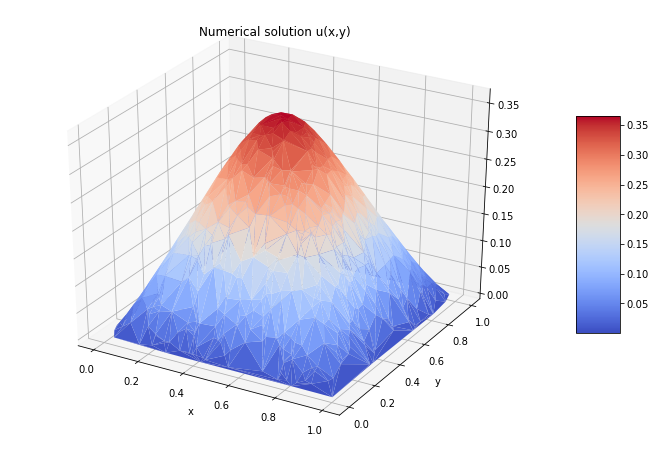

In [8]:
# scatter plot of solution at collocation nodes 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
aa = sol[:N_domain_tot]
X_1_vals = X_domain_tot[range(N_domain_tot), 0]
X_2_vals = X_domain_tot[range(N_domain_tot), 1]
a_surf=ax.plot_trisurf(X_1_vals, X_2_vals, aa, cmap=plt.cm.coolwarm)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Numerical solution u(x,y)')

fig.colorbar(a_surf, shrink= 0.5, aspect = 5)
plt.show()



In [9]:
# use kernel interpolation to extend the solution at test points

def construct_inpTheta(X_test, X_domain, X_boundary):
    N_test = X_test.shape[0]
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    inpTheta = onp.zeros((N_test, 4*N_domain + N_boundary))

    # auxiliary variables to make things readable
    
    # X_test coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=jnp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=jnp.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # test v.s. interior
    XXtd0=jnp.transpose(jnp.tile(Xt0,(N_domain,1)))
    XXtd1=jnp.transpose(jnp.tile(Xt1,(N_domain,1)))
    XXtd0_2=jnp.tile(Xd0,(N_test,1))
    XXtd1_2=jnp.tile(Xd1,(N_test,1))
    
    # test v.s. interior + boundary
    XXtdb0=jnp.transpose(jnp.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=jnp.transpose(jnp.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=jnp.tile(Xdb0,(N_test,1))
    XXtdb1_2=jnp.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = vmap(lambda x1,x2,y1,y2: D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,:N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:, N_domain:2*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: Delta_y_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:, 2*N_domain:3*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: kappa(x1, x2, y1, y2, set_sigma))(XXtdb0.flatten(),XXtdb1.flatten(),XXtdb0_2.flatten(),XXtdb1_2.flatten())
    inpTheta[:, 3*N_domain:] = onp.reshape(val, (N_test, N_domain+N_boundary))
    
    return inpTheta


def extend_solution(X_test, X_domain, X_boundary, L, v):
        
    inp_Theta = construct_inpTheta(X_test, X_domain, X_boundary)
    
    aux = onp.linalg.solve(onp.transpose(L),onp.linalg.solve(L,v))
    
    extended_u = onp.matmul(inp_Theta,aux)
    return extended_u

def sol_and_err_extended(num_pts, X_domain, X_boundary, L, sol):
    # num_pts is the number of test points in each dimension
    hg = 1/(num_pts+1)
    xx= onp.arange(1, num_pts+1)*hg
    yy = onp.arange(1, num_pts+1)*hg
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())
    XXv = onp.expand_dims(XXv, axis=1) 
    YYv = onp.expand_dims(YYv, axis=1) 

    X_test = onp.concatenate((XXv,YYv), axis=1)

    rhs_f = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])
    bdy_g = vmap(u)(X_boundary_tot[:,0], X_boundary_tot[:,1])

    v = sol
    v0 = v[:N_domain_tot]
    v1 = v[N_domain_tot:2*N_domain_tot]
    v2 = v[2*N_domain_tot:]
    v3 = -(rhs_f**2 - v1**2 - v2**2)/epsilon

    vv = jnp.append(v1, v2)
    vv = jnp.append(vv, v3)
    vv = jnp.append(vv, v0)
    vv = jnp.append(vv, bdy_g)

    # extend the solution to test points
    extended_u = extend_solution(X_test, X_domain_tot, X_boundary_tot, L, vv)
    extended_u = extended_u.reshape(num_pts,num_pts)
    
    # err
    mtx_err = abs(extended_u-sol_u)
    
    # L2err
    L2err = jnp.linalg.norm(extended_u-sol_u,'fro')/(num_pts)
    
    # Maxerr
    Maxerr = jnp.max(abs(extended_u-sol_u))
    
    return XX, YY, extended_u, sol_u, mtx_err, L2err, Maxerr

In [10]:
num_pts=100
XX, YY, extended_u, u_truth, mtx_err, L2err, Maxerr = sol_and_err_extended(num_pts, X_domain_tot, X_boundary_tot, L, sol)



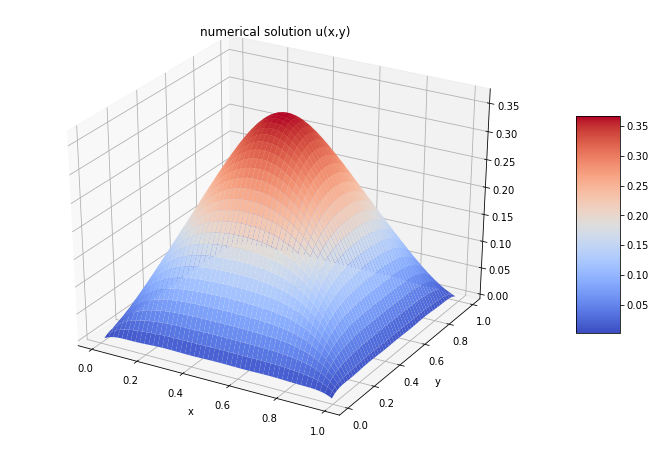

In [11]:
# plot interpolated solution
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_extended_surf=ax.plot_surface(XX, YY, extended_u, cmap=plt.cm.coolwarm)
plt.xlabel('x')
plt.ylabel('y')
plt.title('numerical solution u(x,y)')
fig.colorbar(u_extended_surf, shrink= 0.5, aspect = 5)
plt.show()

sigma = 0.17677669529663687 , nugget = 0.0001 , # pts:  1024 , L2 error:  0.00024384531 , max err:  0.0028863628


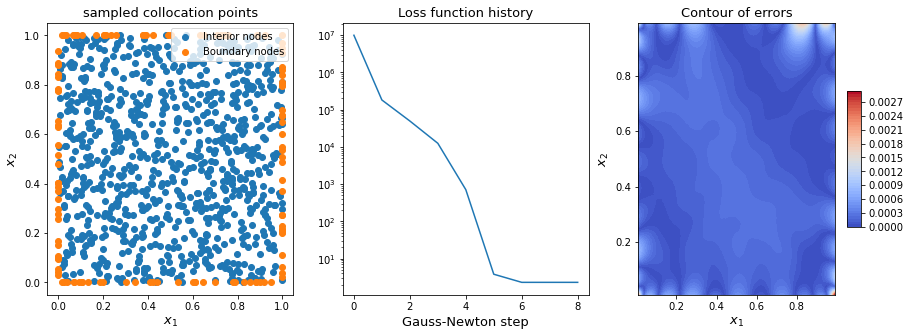

In [12]:
# plot figures
here_fontsize=13

# --------------figure---------------------
fig = plt.figure(figsize=(15,5))

# plot the contour error
ax = fig.add_subplot(133)
u_contourf=ax.contourf(XX, YY, abs(extended_u-u_truth), 50, cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$', fontsize=here_fontsize)
plt.ylabel('$x_2$', fontsize=here_fontsize)
plt.title('Contour of errors', fontsize=here_fontsize)
fig.colorbar(u_contourf, shrink= 0.5, aspect = 10)

# plot the collocation pts
ax = fig.add_subplot(131)
ax.scatter(X_domain_tot[0:N_domain_tot, 0], X_domain_tot[0:N_domain_tot, 1], label='Interior nodes')
ax.scatter(X_boundary_tot[0:N_boundary_tot, 0], X_boundary_tot[0:N_boundary_tot, 1], label='Boundary nodes')
ax.legend(loc="upper right")
plt.title('sampled collocation points', fontsize=here_fontsize)
plt.xlabel('$x_1$', fontsize=here_fontsize)
plt.ylabel('$x_2$', fontsize=here_fontsize) 

# plot the iteration history
ax = fig.add_subplot(132)
plt.plot(onp.arange(max_iter+1),J_hist)
plt.yscale("log")
plt.title('Loss function history', fontsize=here_fontsize)
plt.xlabel('Gauss-Newton step', fontsize=here_fontsize)
print('sigma =', set_sigma, ', nugget =', set_nugget, ', # pts: ', N_domain_tot+N_boundary_tot, ', L2 error: ', L2err, ', max err: ', Maxerr)



In [13]:
# store data
# onp.savez('Eikonal_demon.npz', XX=XX, YY=YY, extended_u=extended_u, u_truth=u_truth, X_domain_tot=X_domain_tot, X_boundary_tot=X_boundary_tot, max_iter=max_iter, J_hist=J_hist)

In [14]:
# convergence curve

arr_N_pts = 2**onp.array([3,4,5,6])-2
arr_total_pts = (arr_N_pts+2)**2
arr_num = onp.shape(arr_N_pts)[0]
epsilon = 1e-1
arr_maxerr = onp.zeros((1, arr_num))
arr_L2err = onp.zeros((1, arr_num))

for i in range(arr_num):
    N_pts = arr_N_pts[i]
    N_domain_tot = N_pts**2
    N_boundary_tot = 4*(N_pts+1)
    X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

    initial_sol = random.normal(0.0, 1.0, (3*N_domain_tot)) # random initial guess
    max_iter = 6
    step_size = 1
    set_sigma = 1/onp.sqrt(N_pts+2)
#     set_sigma = 0.2
    set_nugget = 1e-4
    sol, J_hist, L = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma, epsilon)
    
    num_pts=100
    XX, YY, extended_u, u_truth, mtx_err, L2err, Maxerr = sol_and_err_extended(num_pts, X_domain_tot, X_boundary_tot, L, sol)
    arr_maxerr[0,i] = Maxerr
    arr_L2err[0,i] = L2err
    print('sigma =', set_sigma, ', nugget =', set_nugget, ', # pts: ', N_domain_tot+N_boundary_tot, 'L2 error:', L2err, 'max error:', Maxerr)
    

iter = 0 J = 635256.7
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  367437.03
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  24982.307
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  1078.5023
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  241.99574
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  205.02045
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  177.96132
sigma = 0.35355339059327373 , nugget = 0.0001 , # pts:  64 L2 error: 0.21292673 max error: 0.6008149
iter = 0 J = 2651396.0


KeyboardInterrupt: 

In [17]:
# convergence curve for multiple random instances

arr_N_pts = 2**onp.array([3,4,5,6])-2
arr_total_pts = (arr_N_pts+2)**2
arr_num = onp.shape(arr_N_pts)[0]
epsilon = 1e-1
arr_num_rdm = 10
arr_maxerr = onp.zeros((arr_num_rdm, arr_num))
arr_L2err = onp.zeros((arr_num_rdm, arr_num))


for j in range(arr_num_rdm):
    for i in range(arr_num):
        N_pts = arr_N_pts[i]
        N_domain_tot = N_pts**2
        N_boundary_tot = 4*(N_pts+1)
        X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

        initial_sol = random.normal(0.0, 1.0, (3*N_domain_tot)) # random initial guess
        max_iter = 6
        if i < 2:
            max_iter = 9
        step_size = 1
        set_sigma = 1/onp.sqrt(N_pts+2)
        set_nugget = 1e-4
        sol, J_hist, L = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma, epsilon)
    
        num_pts=100
        XX, YY, extended_u, u_truth, mtx_err, L2err, Maxerr = sol_and_err_extended(num_pts, X_domain_tot, X_boundary_tot, L, sol)
        arr_maxerr[j,i] = Maxerr
        arr_L2err[j,i] = L2err
        print('sigma =', set_sigma, ', nugget =', set_nugget, ', # pts: ', N_domain_tot+N_boundary_tot, 'L2 error:', L2err, 'max error:', Maxerr)
    

iter = 0 J = 717406.2
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  141630.08
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  39259.92
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  2885.2656
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  332.27283
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  68.1696
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  61.316715
iter =  7 epsilon = 0.1 Gauss-Newton step size = 1  J =  60.949677
iter =  8 epsilon = 0.1 Gauss-Newton step size = 1  J =  60.75574
iter =  9 epsilon = 0.1 Gauss-Newton step size = 1  J =  60.626476
sigma = 0.35355339059327373 , nugget = 0.0001 , # pts:  64 L2 error: 0.21247767 max error: 0.5664136
iter = 0 J = 2929005.0
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  160127.42
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  34075.496
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  9558.634
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =

iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  130613.33
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  27547.234
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  10914.307
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  5454.7275
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  23042.809
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  4428.287
iter =  7 epsilon = 0.1 Gauss-Newton step size = 1  J =  14003.618
iter =  8 epsilon = 0.1 Gauss-Newton step size = 1  J =  2152.0635
iter =  9 epsilon = 0.1 Gauss-Newton step size = 1  J =  1467.1791
sigma = 0.25 , nugget = 0.0001 , # pts:  256 L2 error: 0.088272735 max error: 0.36698464
iter = 0 J = 9616287.0
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  164255.0
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  34893.047
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  11838.766
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  4238.026
iter =  5 epsilon = 

iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  169529.12
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  45797.56
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  10615.773
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  279.9911
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  3.4472148
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  2.364469
sigma = 0.17677669529663687 , nugget = 0.0001 , # pts:  1024 L2 error: 0.00087677955 max error: 0.0057303747
iter = 0 J = 40860932.0
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  263772.88
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  41317.523
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  2772.909
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  9.059396
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  1.0454693
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  1.045384
sigma = 0.125 , nugget = 0.0001 , # pts:  4096 L2 error: 0.0001076668

iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  7.803719
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  1.005748
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  1.0057102
sigma = 0.125 , nugget = 0.0001 , # pts:  4096 L2 error: 0.00013684876 max error: 0.001263892


In [22]:
average_maxerr = onp.sum(arr_maxerr, axis = 0)/ arr_num_rdm
std_maxerr = onp.sqrt(onp.sum((arr_maxerr-average_maxerr)**2, axis = 0)/arr_num_rdm)

average_L2err = onp.sum(arr_L2err, axis = 0) / arr_num_rdm
std_L2err = onp.sqrt(onp.sum((arr_L2err-average_L2err)**2, axis = 0)/arr_num_rdm)


print('average_maxerr is', average_maxerr, 'std is', std_maxerr)
print('average_L2err is', average_L2err, 'std is', std_L2err)

average_maxerr is [0.43513881 0.23228879 0.0431571  0.00115018] std is [0.15197651 0.17755339 0.08085258 0.0003287 ]
average_L2err is [1.66147883e-01 6.29982011e-02 8.44767689e-03 1.16909244e-04] std is [7.60146287e-02 5.36993275e-02 1.55963028e-02 1.06509817e-05]


In [29]:
# convergence curve for multiple random instances

arr_N_domain_tot = [1200-120,1800-180,2400-240,3000-300]
arr_N_boundary_tot = [120,180,240,300]

arr_num = onp.shape(arr_N_domain_tot)[0]
arr_num_rdm = 10
epsilon = 1e-1
arr_maxerr = onp.zeros((arr_num_rdm, arr_num))
arr_L2err = onp.zeros((arr_num_rdm, arr_num))

for j in range(arr_num_rdm):
    for i in range(arr_num):
        N_domain_tot = arr_N_domain_tot[i]
        N_boundary_tot = arr_N_boundary_tot[i]
        X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

        initial_sol = random.normal(0.0, 1.0, (3*N_domain_tot)) # random initial guess
        max_iter = 7
        step_size = 1
        set_sigma = 1/ onp.sqrt(onp.sqrt(N_domain_tot+N_boundary_tot))
        set_nugget = 1e-5
        sol, J_hist, L = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma, epsilon)
    
        num_pts=100
        XX, YY, extended_u, u_truth, mtx_err, L2err, Maxerr = sol_and_err_extended(num_pts, X_domain_tot, X_boundary_tot, L, sol)
        arr_maxerr[j,i] = Maxerr
        arr_L2err[j,i] = L2err
        print('sigma =', set_sigma, ', nugget =', set_nugget, ', # pts: ', N_domain_tot+N_boundary_tot, 'L2 error:', L2err, 'max error:', Maxerr)
    

iter = 0 J = 119744264.0
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  1925659.4
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  443023.38
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  146430.7
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  40303.055
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  545.8172
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  5.971079
iter =  7 epsilon = 0.1 Gauss-Newton step size = 1  J =  5.778612
sigma = 0.16990442448471224 , nugget = 1e-05 , # pts:  1200 L2 error: 0.00049273367 max error: 0.012546563
iter = 0 J = 179218380.0
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  2150604.0
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  458872.5
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  136931.81
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  1797.9911
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  4.870203
iter =  6 epsilon = 0.1 Gauss-Newton step siz

iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  3.8385906
iter =  7 epsilon = 0.1 Gauss-Newton step size = 1  J =  3.8386538
sigma = 0.15352597838656357 , nugget = 1e-05 , # pts:  1800 L2 error: 0.00016947933 max error: 0.0021503163
iter = 0 J = 224739000.0
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  2322661.5
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  457202.9
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  97350.68
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  963.13763
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  3.139957
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  2.8706002
iter =  7 epsilon = 0.1 Gauss-Newton step size = 1  J =  2.8705451
sigma = 0.14287202148493997 , nugget = 1e-05 , # pts:  2400 L2 error: 0.00014041411 max error: 0.002017059
iter = 0 J = 280273100.0
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  2426732.0
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  462681.5
it

iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  128601.32
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  1209.5284
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  2.8616683
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  2.6026635
iter =  7 epsilon = 0.1 Gauss-Newton step size = 1  J =  2.6026497
sigma = 0.13512001548070343 , nugget = 1e-05 , # pts:  3000 L2 error: 0.00011058177 max error: 0.00087415625
iter = 0 J = 118594090.0
iter =  1 epsilon = 0.1 Gauss-Newton step size = 1  J =  1884132.1
iter =  2 epsilon = 0.1 Gauss-Newton step size = 1  J =  497355.34
iter =  3 epsilon = 0.1 Gauss-Newton step size = 1  J =  204391.27
iter =  4 epsilon = 0.1 Gauss-Newton step size = 1  J =  38994.98
iter =  5 epsilon = 0.1 Gauss-Newton step size = 1  J =  430073.78
iter =  6 epsilon = 0.1 Gauss-Newton step size = 1  J =  110753.11
iter =  7 epsilon = 0.1 Gauss-Newton step size = 1  J =  155202.39
sigma = 0.16990442448471224 , nugget = 1e-05 , # pts:  1200 L2 

In [30]:
average_maxerr = onp.sum(arr_maxerr, axis = 0)/ arr_num_rdm
std_maxerr = onp.sqrt(onp.sum((arr_maxerr-average_maxerr)**2, axis = 0)/arr_num_rdm)

average_L2err = onp.sum(arr_L2err, axis = 0) / arr_num_rdm
std_L2err = onp.sqrt(onp.sum((arr_L2err-average_L2err)**2, axis = 0)/arr_num_rdm)


print('average_maxerr is', average_maxerr, 'std is', std_maxerr)
print('average_L2err is', average_L2err, 'std is', std_L2err)

average_maxerr is [0.05021895 0.00147835 0.00148219 0.00096612] std is [0.10409501 0.00061751 0.000426   0.00028007]
average_L2err is [0.00954048 0.00013659 0.00012506 0.00011054] std is [2.35944660e-02 1.56826435e-05 1.08602888e-05 1.04270153e-05]


average_maxerr is [0.05021895 0.00147835 0.00148219 0.00096612] std is [0.10409501 0.00061751 0.000426   0.00028007]
average_L2err is [0.00954048 0.00013659 0.00012506 0.00011054] std is [2.35944660e-02 1.56826435e-05 1.08602888e-05 1.04270153e-05]

In [31]:
print(arr_maxerr)
print(arr_L2err)

[[0.01254656 0.00082376 0.00156214 0.00105414]
 [0.00486613 0.00088385 0.00124188 0.00060075]
 [0.00363214 0.00117955 0.00174193 0.00089475]
 [0.01102542 0.00215032 0.00201706 0.00093764]
 [0.00273365 0.00284574 0.00096789 0.00156556]
 [0.00228298 0.00096274 0.00076412 0.00125019]
 [0.34822237 0.00186615 0.00154118 0.00087416]
 [0.10935286 0.00106101 0.00209482 0.00110887]
 [0.00507106 0.00138518 0.00178854 0.00060628]
 [0.00245639 0.00162519 0.00110237 0.00076887]]
[[4.92733670e-04 1.19972443e-04 1.27504172e-04 1.14172632e-04]
 [5.57341787e-04 1.40943914e-04 1.36457340e-04 9.82640995e-05]
 [2.56615924e-04 1.30648870e-04 1.04894993e-04 1.08328473e-04]
 [8.69124546e-04 1.69479332e-04 1.40414108e-04 1.06378189e-04]
 [1.95970948e-04 1.32640344e-04 1.18131378e-04 1.38860909e-04]
 [2.53349514e-04 1.32142450e-04 1.34659043e-04 1.07997759e-04]
 [7.94230774e-02 1.24344006e-04 1.18279269e-04 1.10581772e-04]
 [1.29463924e-02 1.43872589e-04 1.23857491e-04 1.12861722e-04]
 [2.21906914e-04 1.560239

[[0.01254656 0.00082376 0.00156214 0.00105414]
 [0.00486613 0.00088385 0.00124188 0.00060075]
 [0.00363214 0.00117955 0.00174193 0.00089475]
 [0.01102542 0.00215032 0.00201706 0.00093764]
 [0.00273365 0.00284574 0.00096789 0.00156556]
 [0.00228298 0.00096274 0.00076412 0.00125019]
 [0.34822237 0.00186615 0.00154118 0.00087416]
 [0.10935286 0.00106101 0.00209482 0.00110887]
 [0.00507106 0.00138518 0.00178854 0.00060628]
 [0.00245639 0.00162519 0.00110237 0.00076887]]
[[4.92733670e-04 1.19972443e-04 1.27504172e-04 1.14172632e-04]
 [5.57341787e-04 1.40943914e-04 1.36457340e-04 9.82640995e-05]
 [2.56615924e-04 1.30648870e-04 1.04894993e-04 1.08328473e-04]
 [8.69124546e-04 1.69479332e-04 1.40414108e-04 1.06378189e-04]
 [1.95970948e-04 1.32640344e-04 1.18131378e-04 1.38860909e-04]
 [2.53349514e-04 1.32142450e-04 1.34659043e-04 1.07997759e-04]
 [7.94230774e-02 1.24344006e-04 1.18279269e-04 1.10581772e-04]
 [1.29463924e-02 1.43872589e-04 1.23857491e-04 1.12861722e-04]
 [2.21906914e-04 1.56023918e-04 1.13039205e-04 1.03155122e-04]
 [1.88306483e-04 1.15822477e-04 1.33374924e-04 1.04825471e-04]]

In [32]:
arr_maxerr2 = arr_maxerr[[0,1,2,3,4,5,8,9],:]
average_maxerr2 = onp.nanmean(arr_maxerr2, axis=0)
std_maxerr2 = onp.sqrt(onp.nanmean((arr_maxerr2-average_maxerr2)**2, axis = 0))

arr_L2err2 = arr_L2err[[0,1,2,3,4,5,8,9],:]
average_L2err2 = onp.nanmean(arr_L2err2, axis=0)
std_L2err2 = onp.sqrt(onp.nanmean((arr_L2err2-average_L2err2)**2, axis = 0))

print('average_maxerr is', average_maxerr2, 'std is', std_maxerr2)
print('average_L2err is', average_L2err2, 'std is', std_L2err2)

average_maxerr is [0.00557679 0.00148204 0.00139824 0.00095977] std is [0.00373292 0.00066035 0.00041527 0.00030725]
average_L2err is [0.00037942 0.00013721 0.00012606 0.00011025] std is [2.26459048e-04 1.67831209e-05 1.18535020e-05 1.16251425e-05]


average_maxerr is [0.00557679 0.00148204 0.00139824 0.00095977] std is [0.00373292 0.00066035 0.00041527 0.00030725]
average_L2err is [0.00037942 0.00013721 0.00012606 0.00011025] std is [2.26459048e-04 1.67831209e-05 1.18535020e-05 1.16251425e-05]